In [1]:
# -*- coding: utf8

from scipy import stats as ss
from sklearn import datasets

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## Aula 21 - Logística

Temos um conjunto de dados anônimos de aproximadamente 284 lances do jogador Lebron James. Como é comum em variáveis categóricas, representamos a variável dependente como 0 (errou a cesta) ou 1 (acertou a cesta). Esta será a nossa resposta que queremos prever. 

In [4]:
df = pd.read_csv('./lebron.csv')
df.head()

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
3,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0,1
4,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0,1


In [5]:
df.shape

(384, 7)

Vamos iniciar observando a quantidade de acertos por distância da cesta.

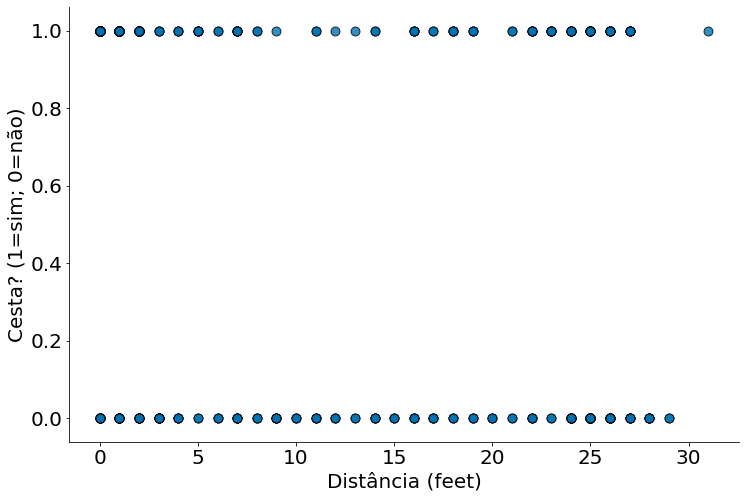

In [6]:
n = df.shape[0]
plt.scatter(df['shot_distance'],
            df['shot_made'],
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

Adicionando algum ruído para melhorar o plot. Observe como os dados se concentram do lado esquerdo.

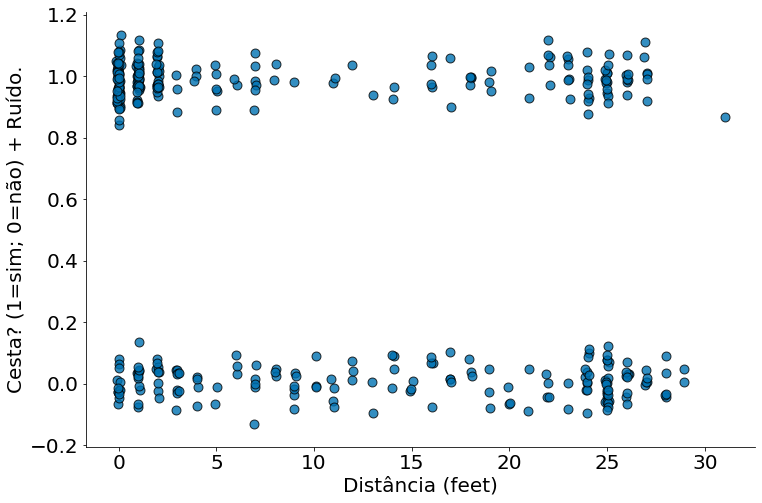

In [7]:
n = df.shape[0]
plt.scatter(df['shot_distance'] + np.random.normal(0, 0.05, size=n),
            df['shot_made'] + np.random.normal(0, 0.05, size=n),
            s=80, alpha=0.8, edgecolors='k')
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não) + Ruído.')
despine()

Como identificar quando Lebron acerta ou erra? Uma primeira tentativa óbvia é usar regressão linear e encontrar o melhor modelo. Observe como a mesma tenta capturar os locais de maior concentração de pontos.

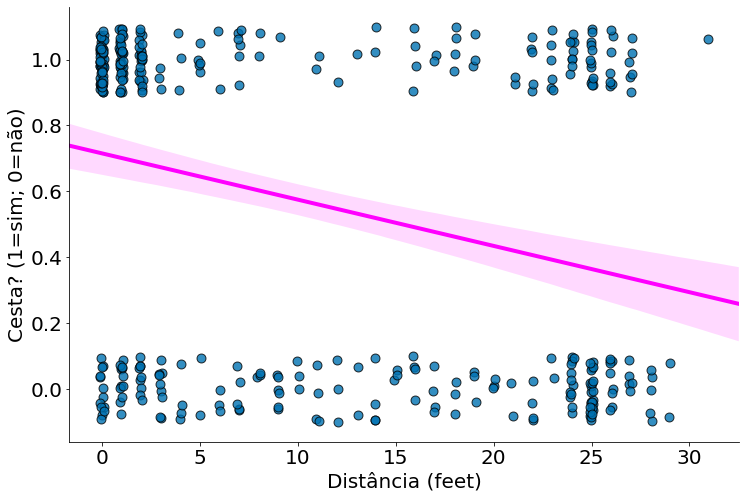

In [8]:
sns.regplot(x='shot_distance', y='shot_made', data=df, n_boot=10000,
            x_jitter=.1, y_jitter=.1,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.xlabel('Distância (feet)')
plt.ylabel('Cesta? (1=sim; 0=não)')
despine()

O resultado é uma curva com inclinação negativa.

In [9]:
ss.linregress(df['shot_distance'], df['shot_made'])

LinregressResult(slope=-0.014055196583349786, intercept=0.7154288863745248, rvalue=-0.2986530102053083, pvalue=2.3711855177639454e-09, stderr=0.0022980071639352555)

Mas essa abordagem leva a alguns problemas imediatos:

* Gostaríamos que nossos resultados previstos fossem 0 ou 1. Tudo bem se eles estiverem entre 0 e 1, já que podemos interpretá-los como probabilidades - uma saída de 0,25 pode significar 25% de chance de ser um membro que paga. Mas as saídas do modelo linear podem ser números positivos enormes ou até números negativos, o que não fica claro como interpretar.

* O que gostaríamos, ao contrário, é que valores positivos grandes de $\mathbf{x_i}~ . \mathbf{\theta}$ (ou `np.dot(x_i,theta)`) correspondam a probabilidades próximas a 1 e que valores negativos grandes correspondam a probabilidades próximas a 0. Podemos conseguir isso aplicando outra função ao resultado.

## A Função Logística

No caso da regressão logística, a gente usa a função logística:

In [10]:
def sigmoid(X, theta):
    return 1.0 / (1.0 + np.exp(-X.dot(theta)))

À medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

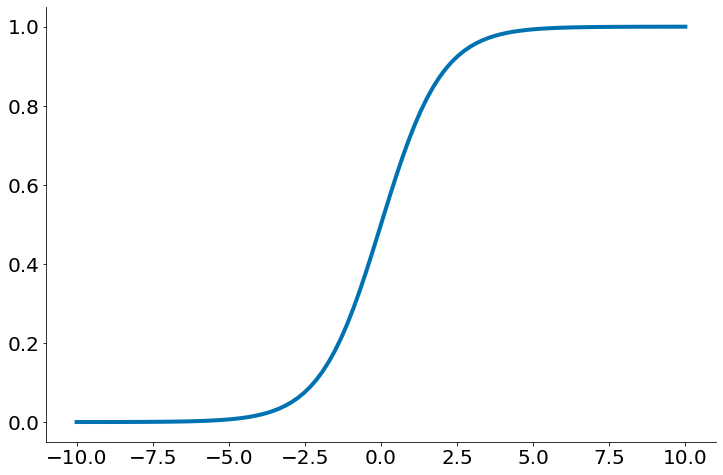

In [11]:
X = np.linspace(-10, 10, 100)[:, None] # vira um vetor coluna
y = sigmoid(X, theta=np.array([1]))
plt.plot(X, y)
despine()

A medida que sua entrada se torna grande e positiva, ela se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, ela se aproxima e se aproxima de 0. Podemos inverter a mesma alterando o valor de theta.

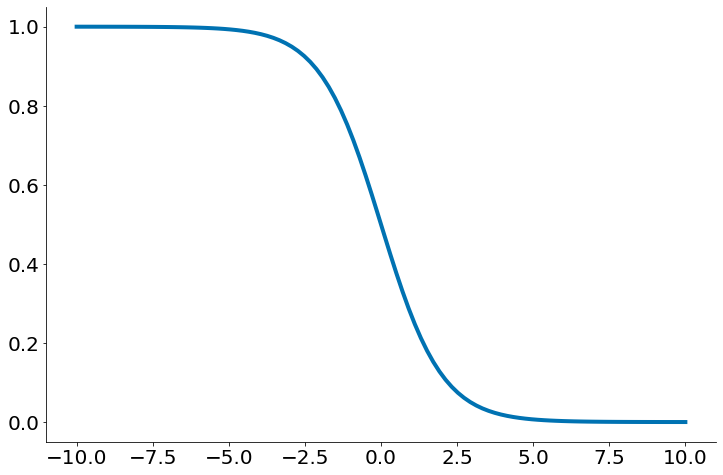

In [12]:
X = np.linspace(-10, 10, 100)[:, None] # vira um vetor coluna
y = sigmoid(X, theta=np.array([-1]))
plt.plot(X, y)
despine()

Além disso, ela tem a propriedade conveniente que sua derivada é dada por:

In [13]:
def logistic_prime(X, theta):
    return sigmoid(X, theta) * (1 - sigmoid(X, theta))

Oberseve a derivada em cada ponto.

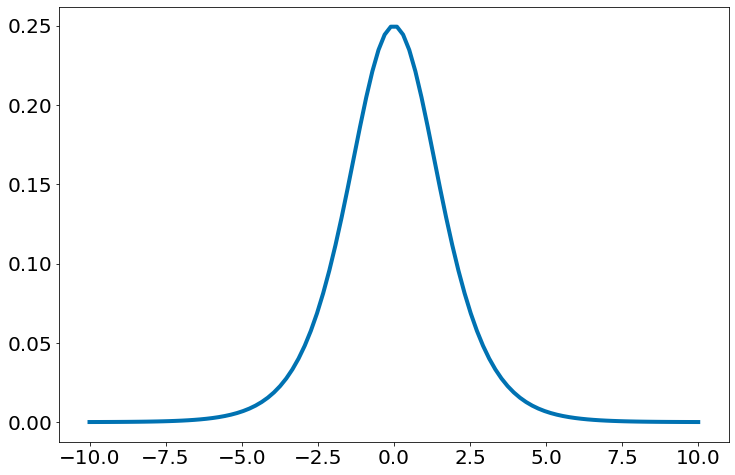

In [14]:
plt.plot(X, logistic_prime(X, np.array([1])))

Daqui a pouco vamos usar a mesma para ajustar um modelo:

$$y_i = f(x_i\theta) + \epsilon_i$$

onde $f$ é a função logística (`logistic`).

Note também que $x_i\theta$, para $j$ variáveis independentes, nada mais é que o modelo linear visto nas aulas anteriores, que é calculado e dado como entrada para a função logística:

$$x_i\theta = \theta_0 + \theta_1 x_1 + \cdots + \theta_j x_j$$

Lembre-se de que, para a regressão linear, ajustamos o modelo minimizando a soma dos erros quadrados, o que acaba escolhendo o $\theta$ que maximiza a probabilidade dos dados.

Aqui os dois não são equivalentes, por isso usaremos gradiente descendente para maximizar a verossimilhança diretamente. Isso significa que precisamos calcular a função de verossimilhança e seu gradiente.

Dado algum $\theta$, nosso modelo diz que cada $y_i$ deve ser igual a 1 com probabilidade $f(x_i\theta)$ e 0 com probabilidade $1 - f(x_i\theta)$.

Em particular, a PDF para $y_i$ pode ser escrita como:

$$p(y_i~|~x_i,\theta) = f(x_i\theta)^{y_i}(1-f(x_i\theta))^{1-y_i}$$

Se $y_i$ é $0$, isso é igual a:

$$1-f(x_i\theta)$$

e se $y_i$ é $1$, é igual a:

$$f(x_i\theta)$$

Acontece que é realmente mais simples maximizar o logaritmo da verossimilhança (*log likelihood*):

$$\log ll_{\theta}(y_i~|~x_i) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$

Como o logaritmo é uma função estritamente crescente, qualquer $\theta$ que maximize o logaritmo da verossimilhança também maximiza a verossimilhança, e vice-versa.

## Cross Entropy

Ao invés de trabalhar na verossimilhança, vamos inverter a mesma (negar). Esta é a definição de cross entropy para a regressão logística. Nos slides da aula derivamos a equivalência entre as duas. [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing).

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log_2(1-f_{\theta}(x_i)) + y_i\log_2(f_{\theta}(x_i))\big)$$

A equação acima é a cross-entropy média por observação.

In [15]:
def cross_entropy_one_sample(x_i, y_i, theta):
    # também podemos escrever y_i * np.log(sigmoid(np.dot(x_i, beta)))
    if y_i == 1:
        return -np.log(sigmoid(np.dot(x_i, theta)))
    else:
        return -np.log(1 - sigmoid(np.dot(x_i, theta)))

O clip abaixo limita os valores para 0.0001 e 0.9999, evita imprecisões numéricas. Ou seja, se o vetor tiver um valor 1.01 por erro numérico, corrigimos para 0.9999.

In [16]:
def cross_entropy_mean(X, y, theta):
    yp = y > 0.5
    logit = sigmoid(X, theta)
    logit = np.clip(logit, 0.00001, 0.99999)
    return -(yp * np.log(logit) + (1 - yp) * np.log(1 - logit)).mean()

A derivada da mesma tem uma forma similar ao da regressão linear. Veja a derivação nos [Slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). Partindo da derivada da logística acima, chegamos em:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big)
$$

Simplificando:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i (y_i - f_{\theta}(x_i)) x_i
$$

Escrevendo em forma vetorizada. Caso não entenda, veja o material da regressão linear múltipla.

In [17]:
def derivadas(theta, X, y):
    return -((y - sigmoid(X, theta)) * X.T).mean(axis=1)

Podemos otimizar por gradiente descendente.

In [18]:
def gd(X, y, lambda_=0.01, tol=0.0000001, max_iter=10000):
    theta = np.ones(X.shape[1])
    print('Iter {}; theta = '.format(0), theta)
    old_err = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = derivadas(theta, X, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err = cross_entropy_mean(X, y, theta)
        if np.abs(old_err - err) <= tol:
            break
        theta = theta_novo
        old_err = err
        print('Iter {}; theta = {}; cross_e = {}'.format(i+1, theta, err))
        i += 1
        if i == max_iter:
            break
    return theta

Executando nos dados. Note o intercepto, necessário.

In [19]:
new_df = df[['shot_distance']].copy()
new_df['intercepto'] = 1
X = new_df[['intercepto', 'shot_distance']].values
y = df['shot_made'].values
X[:10]

array([[ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  0],
       [ 1,  7],
       [ 1, 23],
       [ 1, 25],
       [ 1, 11]])

In [20]:
y[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [21]:
theta = gd(X, y)

Iter 0; theta =  [1. 1.]
Iter 1; theta = [0.99639116 0.93815854]; cross_e = 3.8372185688014135
Iter 2; theta = [0.99280026 0.87634372]; cross_e = 3.7972328908301627
Iter 3; theta = [0.98922885 0.81455913]; cross_e = 3.7523457095542145
Iter 4; theta = [0.98567869 0.7528091 ]; cross_e = 3.701900424045673
Iter 5; theta = [0.98215177 0.69109896]; cross_e = 3.647864840031765
Iter 6; theta = [0.97865039 0.62943541]; cross_e = 3.583606296758237
Iter 7; theta = [0.97517726 0.56782707]; cross_e = 3.50879824690689
Iter 8; theta = [0.97173556 0.50628547]; cross_e = 3.417271400163878
Iter 9; theta = [0.96832919 0.44482658]; cross_e = 3.307931926255197
Iter 10; theta = [0.96496306 0.38347379]; cross_e = 3.1751856571604953
Iter 11; theta = [0.9616436  0.32226391]; cross_e = 2.9128724140347977
Iter 12; theta = [0.95837982 0.26126117]; cross_e = 2.5431525030105306
Iter 13; theta = [0.95518564 0.20059524]; cross_e = 2.1708964854025012
Iter 14; theta = [0.95208606 0.14057961]; cross_e = 1.80357973424099

Agora vamos pegar os valores maiores do que 0.5 como previsões.

In [22]:
previsoes = sigmoid(X, theta) > 0.5
print(previsoes)

[ True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True False  True  True  True  True False False  True  True  True
 False  True False  True False  True False False  True  True False  True
 False  True  True  True False False  True False False False False  True
  True  True  True  True False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True False False  True  True  True  True
  True False False  True  True  True  True False  True False False  True
 False False  True  True False False  True  True  True  True  True False
 False False  True  True  True False False  True False  True  True False
  True  True False  True False  True False False  True False False False
  True False  True False False  True  True False  True  True False False
  True  True False False False False False False Fa

Vamos ver nosso acerto

In [23]:
print(previsoes == y)

[False  True  True  True  True  True  True False False False False  True
  True False False  True False False  True  True False  True False False
  True  True False  True  True False  True  True  True  True  True False
  True  True  True False False False False  True False  True False  True
  True False False False False  True  True False False  True  True  True
  True  True False  True False  True  True False  True  True False False
  True False False False  True  True  True  True  True  True  True  True
 False  True  True False False False False  True  True  True  True False
  True  True  True False False False  True False  True False  True False
 False False False  True False  True  True False  True False  True False
 False  True  True  True  True False False  True  True  True False  True
  True  True False False  True  True  True  True  True False  True False
  True  True  True  True False  True  True  True  True  True False  True
 False  True False  True False  True  True  True Fa

Taxa de acertos

In [24]:
print((previsoes == y).mean())

0.6171875


Observe como otimiza a função de forma correta. Para não gastar mais tempo com código na mão, ajustes de taxas de perda, etc etc etc. Podemos usar sklearn

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# loss = log, logistic
# penalty = none, sem regularizar
# fit_intercept = false, colocamos na marra em X já um intercepto
# penalty == none pois não vamos regularizar
# solver indica como o sklearn vai otimizar
model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model.fit(X, y) ### Execute gradiente descendente!!!

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Fazendo treino e testes!

In [27]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model = model.fit(X_train, y_train)

O modelo não é muito bom nessa base :-( Note que o resultado é quase o mesmo do nosso GD na mão.

In [28]:
model.predict(X_train)
(y_train == model.predict(X_train)).mean()

0.6

In [29]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.6358695652173914

Colocando mais features

In [30]:
X = df[['shot_distance', 'minute']].values
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = LogisticRegression(penalty='none', fit_intercept=True, solver='lbfgs')
model = model.fit(X_train, y_train)

In [31]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

0.6630434782608695

Vamos agora colocar bastante features. Todo valor categórico vai virar uma coluna, esse é o onehot method.

In [32]:
df_dummies = pd.get_dummies(df, 'action_type', 'shot_type', 'opponent', drop_first=True)
del df_dummies['game_date']
df_dummies.head()

,minute,shot_distance,shot_made,action_typeshot_typeGSW,action_typeshot_typeIND,action_typeshot_typeTOR,action_typeshot_typenan,action_typeshot_typeAlley Oop Layup shot,action_typeshot_typeCutting Dunk Shot,action_typeshot_typeCutting Finger Roll Layup Shot,...,action_typeshot_typeRunning Reverse Layup Shot,action_typeshot_typeStep Back Jump shot,action_typeshot_typeTip Layup Shot,action_typeshot_typeTurnaround Fadeaway Bank Jump Shot,action_typeshot_typeTurnaround Fadeaway shot,action_typeshot_typeTurnaround Hook Shot,action_typeshot_typeTurnaround Jump Shot,action_typeshot_typenan,action_typeshot_type3PT Field Goal,action_typeshot_typenan
0,10,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Atributos categóricos não podem ser usado como valores numéricos. Sempre pense em uma distância, não faz sentido para um shot-type. Ao colocar casa categoria em uma coluna, o algoritmo trata como presença e ausência do atributo.

In [33]:
X = df_dummies.values
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

model = LogisticRegression(penalty='none', fit_intercept=True, solver='lbfgs')
model = model.fit(X_train, y_train)

Quase perfeito

In [34]:
model.predict(X_test)
(y_test == model.predict(X_test)).mean()

1.0

## Dados Sintéticos

Para garantir que nosso GD está mais ou menos ok, vamos usar dados sintéticos.

Observe com dados bem comportados como a previsão é quase perfeita! Como esperado.

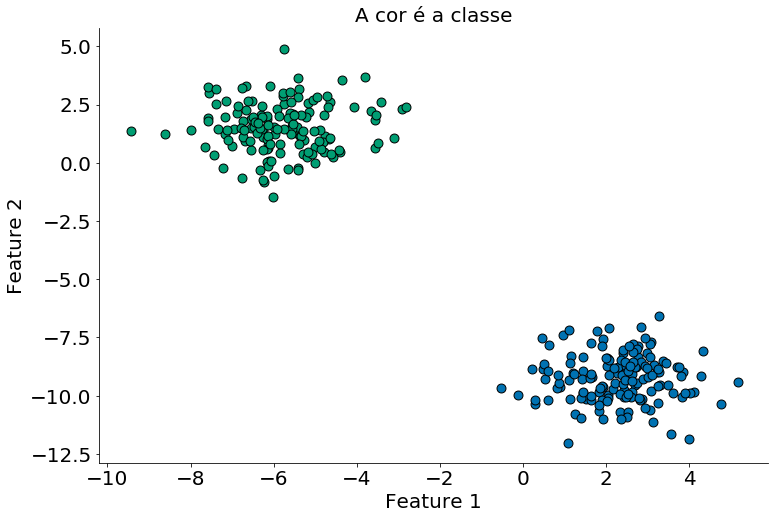

In [35]:
X, y = datasets.make_blobs(n_samples=300, centers=2, n_features=2)
ones = y == 1
plt.scatter(X[:, 0][ones], X[:, 1][ones], edgecolors='k', s=80)
plt.scatter(X[:, 0][~ones], X[:, 1][~ones], edgecolors='k', s=80)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('A cor é a classe')
despine()

In [36]:
X_train = X[:200]
X_test = X[200:]
y_train = y[:200]
y_test = y[200:]

theta = gd(X_train, y_train)

Iter 0; theta =  [1. 1.]
Iter 1; theta = [1.01170766 0.9565856 ]; cross_e = 3.24293651726882
Iter 2; theta = [1.02327682 0.91328599]; cross_e = 3.041075880751813
Iter 3; theta = [1.03471434 0.87011533]; cross_e = 2.840554359186284
Iter 4; theta = [1.04602193 0.82709886]; cross_e = 2.6414971792204436
Iter 5; theta = [1.05719452 0.78427762]; cross_e = 2.444146135795054
Iter 6; theta = [1.06821824 0.74171457]; cross_e = 2.24890396910947
Iter 7; theta = [1.07906805 0.69950216]; cross_e = 2.056389555790831
Iter 8; theta = [1.08970535 0.65777053]; cross_e = 1.8674995122786635
Iter 9; theta = [1.10007629 0.61669465]; cross_e = 1.6834631712790427
Iter 10; theta = [1.11011213 0.57649692]; cross_e = 1.5058652608147702
Iter 11; theta = [1.11973296 0.53744096]; cross_e = 1.3365992627236682
Iter 12; theta = [1.12885552 0.49981362]; cross_e = 1.1777177510306627
Iter 13; theta = [1.13740399 0.4638963 ]; cross_e = 1.031178692734504
Iter 14; theta = [1.14532068 0.42993189]; cross_e = 0.8985424557787215

Iter 127; theta = [ 1.24744186 -0.16130856]; cross_e = 0.014349770948482372
Iter 128; theta = [ 1.24760488 -0.16247556]; cross_e = 0.014208856883693291
Iter 129; theta = [ 1.24776647 -0.16363122]; cross_e = 0.014070684132484485
Iter 130; theta = [ 1.24792665 -0.16477574]; cross_e = 0.013935175100484724
Iter 131; theta = [ 1.24808544 -0.16590932]; cross_e = 0.013802255048557114
Iter 132; theta = [ 1.24824288 -0.16703218]; cross_e = 0.013671851964237026
Iter 133; theta = [ 1.24839898 -0.16814449]; cross_e = 0.013543896439989205
Iter 134; theta = [ 1.24855378 -0.16924646]; cross_e = 0.01341832155786926
Iter 135; theta = [ 1.2487073  -0.17033826]; cross_e = 0.013295062780202725
Iter 136; theta = [ 1.24885956 -0.17142008]; cross_e = 0.013174057845921188
Iter 137; theta = [ 1.24901059 -0.1724921 ]; cross_e = 0.013055246672219648
Iter 138; theta = [ 1.2491604  -0.17355447]; cross_e = 0.012938571261221377
Iter 139; theta = [ 1.24930903 -0.17460737]; cross_e = 0.012823975611357376
Iter 140; the

Iter 261; theta = [ 1.2622216  -0.26090186]; cross_e = 0.006226005908104442
Iter 262; theta = [ 1.2623016 -0.2613986]; cross_e = 0.0062005262045164745
Iter 263; theta = [ 1.26238133 -0.26189319]; cross_e = 0.006175265934274265
Iter 264; theta = [ 1.2624608  -0.26238565]; cross_e = 0.0061502222867771475
Iter 265; theta = [ 1.26254001 -0.26287599]; cross_e = 0.0061253924989042
Iter 266; theta = [ 1.26261897 -0.26336424]; cross_e = 0.006100773854021725
Iter 267; theta = [ 1.26269767 -0.26385041]; cross_e = 0.0060763636810155
Iter 268; theta = [ 1.26277612 -0.26433452]; cross_e = 0.006052159353346939
Iter 269; theta = [ 1.26285432 -0.26481658]; cross_e = 0.006028158288132543
Iter 270; theta = [ 1.26293226 -0.26529662]; cross_e = 0.006004357945245937
Iter 271; theta = [ 1.26300997 -0.26577465]; cross_e = 0.005980755826441908
Iter 272; theta = [ 1.26308743 -0.26625069]; cross_e = 0.0059573494745017086
Iter 273; theta = [ 1.26316464 -0.26672475]; cross_e = 0.0059341364723992105
Iter 274; thet

Iter 394; theta = [ 1.27115204 -0.31309675]; cross_e = 0.004069504496747264
Iter 395; theta = [ 1.27120946 -0.31341096]; cross_e = 0.004059259792839511
Iter 396; theta = [ 1.27126678 -0.3137243 ]; cross_e = 0.0040490711839579405
Iter 397; theta = [ 1.27132399 -0.31403678]; cross_e = 0.004038938208876479
Iter 398; theta = [ 1.27138109 -0.3143484 ]; cross_e = 0.004028860411399009
Iter 399; theta = [ 1.27143808 -0.31465917]; cross_e = 0.004018837340291183
Iter 400; theta = [ 1.27149496 -0.31496908]; cross_e = 0.004008868549213407
Iter 401; theta = [ 1.27155174 -0.31527815]; cross_e = 0.003998953596654813
Iter 402; theta = [ 1.27160842 -0.31558638]; cross_e = 0.003989092045868351
Iter 403; theta = [ 1.27166498 -0.31589378]; cross_e = 0.003979283464806937
Iter 404; theta = [ 1.27172145 -0.31620034]; cross_e = 0.003969527426060563
Iter 405; theta = [ 1.27177781 -0.31650608]; cross_e = 0.003959823506794471
Iter 406; theta = [ 1.27183406 -0.31681099]; cross_e = 0.003950171288688258
Iter 407; t

Iter 508; theta = [ 1.27710772 -0.3442593 ]; cross_e = 0.003177843374368231
Iter 509; theta = [ 1.27715552 -0.34449802]; cross_e = 0.003171897801883563
Iter 510; theta = [ 1.27720326 -0.34473623]; cross_e = 0.003165976927265559
Iter 511; theta = [ 1.27725093 -0.34497395]; cross_e = 0.003160080595586384
Iter 512; theta = [ 1.27729854 -0.34521116]; cross_e = 0.0031542086532109176
Iter 513; theta = [ 1.27734608 -0.34544788]; cross_e = 0.003148360947783384
Iter 514; theta = [ 1.27739356 -0.34568411]; cross_e = 0.003142537328214008
Iter 515; theta = [ 1.27744098 -0.34591984]; cross_e = 0.003136737644665929
Iter 516; theta = [ 1.27748833 -0.34615508]; cross_e = 0.0031309617485423533
Iter 517; theta = [ 1.27753562 -0.34638984]; cross_e = 0.0031252094924736394
Iter 518; theta = [ 1.27758284 -0.34662411]; cross_e = 0.0031194807303047867
Iter 519; theta = [ 1.27763001 -0.34685789]; cross_e = 0.0031137753170828726
Iter 520; theta = [ 1.27767711 -0.3470912 ]; cross_e = 0.003108093109044849
Iter 52

Iter 638; theta = [ 1.28285218 -0.3717102 ]; cross_e = 0.0025682145919306214
Iter 639; theta = [ 1.28289321 -0.37189755]; cross_e = 0.002564527232497968
Iter 640; theta = [ 1.28293419 -0.3720846 ]; cross_e = 0.0025608518475274465
Iter 641; theta = [ 1.28297513 -0.37227133]; cross_e = 0.002557188377994116
Iter 642; theta = [ 1.28301603 -0.37245776]; cross_e = 0.002553536765260999
Iter 643; theta = [ 1.28305689 -0.37264388]; cross_e = 0.002549896951075831
Iter 644; theta = [ 1.28309771 -0.37282969]; cross_e = 0.0025462688775679497
Iter 645; theta = [ 1.28313849 -0.3730152 ]; cross_e = 0.0025426524872451785
Iter 646; theta = [ 1.28317922 -0.37320041]; cross_e = 0.002539047722990727
Iter 647; theta = [ 1.28321992 -0.37338531]; cross_e = 0.0025354545280601225
Iter 648; theta = [ 1.28326057 -0.37356992]; cross_e = 0.0025318728460782115
Iter 649; theta = [ 1.28330119 -0.37375422]; cross_e = 0.0025283026295467954
Iter 650; theta = [ 1.28334176 -0.37393822]; cross_e = 0.0025247438346726226
Iter

Iter 752; theta = [ 1.28728716 -0.3912912 ]; cross_e = 0.0022129849666693525
Iter 753; theta = [ 1.28732412 -0.39144883]; cross_e = 0.0022103583929201608
Iter 754; theta = [ 1.28736105 -0.39160624]; cross_e = 0.002207738964689192
Iter 755; theta = [ 1.28739794 -0.39176343]; cross_e = 0.002205126652354778
Iter 756; theta = [ 1.28743481 -0.3919204 ]; cross_e = 0.00220252142645928
Iter 757; theta = [ 1.28747165 -0.39207716]; cross_e = 0.0021999232577079144
Iter 758; theta = [ 1.28750845 -0.3922337 ]; cross_e = 0.002197332116967615
Iter 759; theta = [ 1.28754523 -0.39239002]; cross_e = 0.0021947479752659404
Iter 760; theta = [ 1.28758197 -0.39254613]; cross_e = 0.002192170803789987
Iter 761; theta = [ 1.28761869 -0.39270202]; cross_e = 0.0021896005738852274
Iter 762; theta = [ 1.28765537 -0.3928577 ]; cross_e = 0.0021870372570545176
Iter 763; theta = [ 1.28769203 -0.39301317]; cross_e = 0.002184480824956919
Iter 764; theta = [ 1.28772866 -0.39316842]; cross_e = 0.0021819312494066813
Iter 7

Iter 969; theta = [ 1.29469752 -0.42120403]; cross_e = 0.001772108966620608
Iter 970; theta = [ 1.29472924 -0.42132514]; cross_e = 0.0017705390862102254
Iter 971; theta = [ 1.29476094 -0.42144612]; cross_e = 0.0017689724576473987
Iter 972; theta = [ 1.29479263 -0.42156698]; cross_e = 0.0017674090706010738
Iter 973; theta = [ 1.29482429 -0.4216877 ]; cross_e = 0.001765848914784101
Iter 974; theta = [ 1.29485594 -0.4218083 ]; cross_e = 0.0017642919799530671
Iter 975; theta = [ 1.29488757 -0.42192877]; cross_e = 0.0017627382559080073
Iter 976; theta = [ 1.29491918 -0.42204912]; cross_e = 0.001761187732492226
Iter 977; theta = [ 1.29495077 -0.42216933]; cross_e = 0.0017596403995920596
Iter 978; theta = [ 1.29498234 -0.42228942]; cross_e = 0.0017580962471365914
Iter 979; theta = [ 1.29501389 -0.42240938]; cross_e = 0.001756555265097522
Iter 980; theta = [ 1.29504543 -0.42252922]; cross_e = 0.0017550174434888513
Iter 981; theta = [ 1.29507694 -0.42264892]; cross_e = 0.0017534827723667066
Ite

Iter 1082; theta = [ 1.29816891 -0.43413292]; cross_e = 0.0016131248157338135
Iter 1083; theta = [ 1.29819868 -0.43424102]; cross_e = 0.001611865987568629
Iter 1084; theta = [ 1.29822843 -0.43434901]; cross_e = 0.0016106094754456126
Iter 1085; theta = [ 1.29825816 -0.43445691]; cross_e = 0.001609355272809304
Iter 1086; theta = [ 1.29828788 -0.4345647 ]; cross_e = 0.0016081033731291145
Iter 1087; theta = [ 1.29831758 -0.43467239]; cross_e = 0.0016068537698992003
Iter 1088; theta = [ 1.29834726 -0.43477997]; cross_e = 0.0016056064566383652
Iter 1089; theta = [ 1.29837694 -0.43488746]; cross_e = 0.0016043614268899241
Iter 1090; theta = [ 1.29840659 -0.43499484]; cross_e = 0.0016031186742216036
Iter 1091; theta = [ 1.29843623 -0.43510212]; cross_e = 0.001601878192225421
Iter 1092; theta = [ 1.29846585 -0.43520931]; cross_e = 0.0016006399745175487
Iter 1093; theta = [ 1.29849546 -0.43531639]; cross_e = 0.0015994040147382352
Iter 1094; theta = [ 1.29852506 -0.43542337]; cross_e = 0.001598170

Iter 1295; theta = [ 1.30419009 -0.45511149]; cross_e = 0.0013886060035082932
Iter 1296; theta = [ 1.304217   -0.45520141]; cross_e = 0.001387724038562781
Iter 1297; theta = [ 1.3042439  -0.45529126]; cross_e = 0.0013868434111669213
Iter 1298; theta = [ 1.30427078 -0.45538104]; cross_e = 0.0013859641181834814
Iter 1299; theta = [ 1.30429766 -0.45547075]; cross_e = 0.0013850861564851248
Iter 1300; theta = [ 1.30432452 -0.45556039]; cross_e = 0.001384209522954376
Iter 1301; theta = [ 1.30435137 -0.45564996]; cross_e = 0.001383334214483527
Iter 1302; theta = [ 1.30437821 -0.45573946]; cross_e = 0.0013824602279746533
Iter 1303; theta = [ 1.30440504 -0.45582888]; cross_e = 0.001381587560339552
Iter 1304; theta = [ 1.30443185 -0.45591824]; cross_e = 0.0013807162084997382
Iter 1305; theta = [ 1.30445866 -0.45600753]; cross_e = 0.0013798461693863475
Iter 1306; theta = [ 1.30448546 -0.45609674]; cross_e = 0.001378977439940132
Iter 1307; theta = [ 1.30451224 -0.45618589]; cross_e = 0.00137811001

Iter 1407; theta = [ 1.30713583 -0.46476632]; cross_e = 0.0012974816598612514
Iter 1408; theta = [ 1.30716154 -0.46484895]; cross_e = 0.0012967320323749437
Iter 1409; theta = [ 1.30718724 -0.46493152]; cross_e = 0.0012959834446380498
Iter 1410; theta = [ 1.30721293 -0.46501403]; cross_e = 0.0012952358944143788
Iter 1411; theta = [ 1.30723861 -0.46509648]; cross_e = 0.0012944893794741893
Iter 1412; theta = [ 1.30726429 -0.46517887]; cross_e = 0.0012937438975941975
Iter 1413; theta = [ 1.30728995 -0.4652612 ]; cross_e = 0.0012929994465575145
Iter 1414; theta = [ 1.3073156  -0.46534347]; cross_e = 0.0012922560241536837
Iter 1415; theta = [ 1.30734124 -0.46542569]; cross_e = 0.0012915136281785994
Iter 1416; theta = [ 1.30736687 -0.46550784]; cross_e = 0.0012907722564344864
Iter 1417; theta = [ 1.3073925  -0.46558993]; cross_e = 0.001290031906729944
Iter 1418; theta = [ 1.30741811 -0.46567197]; cross_e = 0.0012892925768798159
Iter 1419; theta = [ 1.30744371 -0.46575395]; cross_e = 0.0012885

Iter 1642; theta = [ 1.31292743 -0.48270658]; cross_e = 0.0011458193043861406
Iter 1643; theta = [ 1.31295109 -0.48277722]; cross_e = 0.0011452639471978198
Iter 1644; theta = [ 1.31297474 -0.48284781]; cross_e = 0.0011447092421886123
Iter 1645; theta = [ 1.31299839 -0.48291836]; cross_e = 0.0011441551881649446
Iter 1646; theta = [ 1.31302202 -0.48298886]; cross_e = 0.0011436017839362214
Iter 1647; theta = [ 1.31304565 -0.48305932]; cross_e = 0.0011430490283147413
Iter 1648; theta = [ 1.31306927 -0.48312974]; cross_e = 0.0011424969201157494
Iter 1649; theta = [ 1.31309288 -0.48320011]; cross_e = 0.0011419454581573982
Iter 1650; theta = [ 1.31311649 -0.48327044]; cross_e = 0.0011413946412607476
Iter 1651; theta = [ 1.31314008 -0.48334073]; cross_e = 0.0011408444682497686
Iter 1652; theta = [ 1.31316367 -0.48341098]; cross_e = 0.001140294937951287
Iter 1653; theta = [ 1.31318726 -0.48348118]; cross_e = 0.0011397460491950485
Iter 1654; theta = [ 1.31321083 -0.48355134]; cross_e = 0.0011391

Iter 1830; theta = [ 1.31724806 -0.49527482]; cross_e = 0.0010517085220717564
Iter 1831; theta = [ 1.3172704  -0.49533812]; cross_e = 0.0010512575975670437
Iter 1832; theta = [ 1.31729273 -0.49540138]; cross_e = 0.0010508071441246627
Iter 1833; theta = [ 1.31731506 -0.49546462]; cross_e = 0.001050357160974894
Iter 1834; theta = [ 1.31733738 -0.49552781]; cross_e = 0.001049907647349706
Iter 1835; theta = [ 1.31735969 -0.49559097]; cross_e = 0.0010494586024827359
Iter 1836; theta = [ 1.31738199 -0.4956541 ]; cross_e = 0.0010490100256093705
Iter 1837; theta = [ 1.31740429 -0.49571719]; cross_e = 0.0010485619159666243
Iter 1838; theta = [ 1.31742659 -0.49578025]; cross_e = 0.0010481142727932161
Iter 1839; theta = [ 1.31744887 -0.49584327]; cross_e = 0.00104766709532951
Iter 1840; theta = [ 1.31747115 -0.49590626]; cross_e = 0.001047220382817573
Iter 1841; theta = [ 1.31749343 -0.49596921]; cross_e = 0.001046774134501127
Iter 1842; theta = [ 1.31751569 -0.49603213]; cross_e = 0.001046328349

Iter 1979; theta = [ 1.32050844 -0.50434158]; cross_e = 0.0009893304723878524
Iter 1980; theta = [ 1.32052988 -0.50440007]; cross_e = 0.0009889421163271053
Iter 1981; theta = [ 1.32055132 -0.50445854]; cross_e = 0.0009885541330460878
Iter 1982; theta = [ 1.32057274 -0.50451697]; cross_e = 0.0009881665219835605
Iter 1983; theta = [ 1.32059417 -0.50457538]; cross_e = 0.0009877792825794234
Iter 1984; theta = [ 1.32061558 -0.50463376]; cross_e = 0.000987392414274724
Iter 1985; theta = [ 1.32063699 -0.5046921 ]; cross_e = 0.0009870059165116452
Iter 1986; theta = [ 1.3206584  -0.50475042]; cross_e = 0.0009866197887334934
Iter 1987; theta = [ 1.3206798  -0.50480871]; cross_e = 0.0009862340303847153
Iter 1988; theta = [ 1.32070119 -0.50486697]; cross_e = 0.0009858486409108761
Iter 1989; theta = [ 1.32072258 -0.5049252 ]; cross_e = 0.0009854636197586695
Iter 1990; theta = [ 1.32074396 -0.5049834 ]; cross_e = 0.000985078966375898
Iter 1991; theta = [ 1.32076534 -0.50504157]; cross_e = 0.00098469

Iter 2124; theta = [ 1.32356009 -0.51252714]; cross_e = 0.0009366513255329025
Iter 2125; theta = [ 1.32358076 -0.51258162]; cross_e = 0.0009363116993815195
Iter 2126; theta = [ 1.32360141 -0.51263607]; cross_e = 0.0009359723752267597
Iter 2127; theta = [ 1.32362206 -0.51269049]; cross_e = 0.0009356333526463977
Iter 2128; theta = [ 1.32364271 -0.51274489]; cross_e = 0.0009352946312189739
Iter 2129; theta = [ 1.32366335 -0.51279927]; cross_e = 0.0009349562105238501
Iter 2130; theta = [ 1.32368399 -0.51285361]; cross_e = 0.0009346180901411924
Iter 2131; theta = [ 1.32370462 -0.51290794]; cross_e = 0.000934280269651935
Iter 2132; theta = [ 1.32372525 -0.51296223]; cross_e = 0.0009339427486378116
Iter 2133; theta = [ 1.32374587 -0.51301651]; cross_e = 0.0009336055266813592
Iter 2134; theta = [ 1.32376649 -0.51307075]; cross_e = 0.0009332686033658746
Iter 2135; theta = [ 1.3237871  -0.51312497]; cross_e = 0.0009329319782754486
Iter 2136; theta = [ 1.32380771 -0.51317917]; cross_e = 0.0009325

Iter 2270; theta = [ 1.32652507 -0.5202198 ]; cross_e = 0.0008900615921094111
Iter 2271; theta = [ 1.32654504 -0.52027075]; cross_e = 0.0008897619617520017
Iter 2272; theta = [ 1.32656499 -0.52032169]; cross_e = 0.0008894625793193678
Iter 2273; theta = [ 1.32658494 -0.5203726 ]; cross_e = 0.0008891634444881849
Iter 2274; theta = [ 1.32660489 -0.52042349]; cross_e = 0.0008888645569356937
Iter 2275; theta = [ 1.32662484 -0.52047435]; cross_e = 0.0008885659163397103
Iter 2276; theta = [ 1.32664477 -0.5205252 ]; cross_e = 0.0008882675223786403
Iter 2277; theta = [ 1.32666471 -0.52057602]; cross_e = 0.0008879693747314174
Iter 2278; theta = [ 1.32668464 -0.52062682]; cross_e = 0.0008876714730775703
Iter 2279; theta = [ 1.32670456 -0.5206776 ]; cross_e = 0.0008873738170971882
Iter 2280; theta = [ 1.32672448 -0.52072835]; cross_e = 0.0008870764064708938
Iter 2281; theta = [ 1.3267444  -0.52077908]; cross_e = 0.0008867792408799225
Iter 2282; theta = [ 1.32676431 -0.5208298 ]; cross_e = 0.000886

Iter 2414; theta = [ 1.32935408 -0.52733498]; cross_e = 0.0008493222058412983
Iter 2415; theta = [ 1.32937342 -0.52738289]; cross_e = 0.0008490552358359801
Iter 2416; theta = [ 1.32939275 -0.52743078]; cross_e = 0.0008487884724773527
Iter 2417; theta = [ 1.32941208 -0.52747864]; cross_e = 0.000848521915512777
Iter 2418; theta = [ 1.3294314  -0.52752649]; cross_e = 0.0008482555646899989
Iter 2419; theta = [ 1.32945072 -0.52757432]; cross_e = 0.000847989419757208
Iter 2420; theta = [ 1.32947003 -0.52762213]; cross_e = 0.000847723480462989
Iter 2421; theta = [ 1.32948934 -0.52766991]; cross_e = 0.0008474577465563577
Iter 2422; theta = [ 1.32950865 -0.52771768]; cross_e = 0.0008471922177867365
Iter 2423; theta = [ 1.32952796 -0.52776543]; cross_e = 0.0008469268939039561
Iter 2424; theta = [ 1.32954725 -0.52781316]; cross_e = 0.0008466617746582827
Iter 2425; theta = [ 1.32956655 -0.52786087]; cross_e = 0.0008463968598003799
Iter 2426; theta = [ 1.32958584 -0.52790856]; cross_e = 0.000846132

Iter 2562; theta = [ 1.33217217 -0.53421735]; cross_e = 0.000811934069568916
Iter 2563; theta = [ 1.33219092 -0.53426249]; cross_e = 0.0008116951544329987
Iter 2564; theta = [ 1.33220966 -0.5343076 ]; cross_e = 0.000811456412671825
Iter 2565; theta = [ 1.33222841 -0.5343527 ]; cross_e = 0.0008112178440862477
Iter 2566; theta = [ 1.33224715 -0.53439778]; cross_e = 0.0008109794484773991
Iter 2567; theta = [ 1.33226588 -0.53444285]; cross_e = 0.0008107412256467724
Iter 2568; theta = [ 1.33228462 -0.5344879 ]; cross_e = 0.0008105031753961273
Iter 2569; theta = [ 1.33230335 -0.53453292]; cross_e = 0.0008102652975275503
Iter 2570; theta = [ 1.33232207 -0.53457794]; cross_e = 0.0008100275918434311
Iter 2571; theta = [ 1.33234079 -0.53462293]; cross_e = 0.000809790058146485
Iter 2572; theta = [ 1.33235951 -0.53466791]; cross_e = 0.0008095526962396995
Iter 2573; theta = [ 1.33237822 -0.53471286]; cross_e = 0.0008093155059263963
Iter 2574; theta = [ 1.33239693 -0.53475781]; cross_e = 0.000809078

Iter 2706; theta = [ 1.33483455 -0.54054169]; cross_e = 0.0007792233518757819
Iter 2707; theta = [ 1.33485278 -0.54058442]; cross_e = 0.0007790074936020617
Iter 2708; theta = [ 1.33487101 -0.54062713]; cross_e = 0.0007787917829454818
Iter 2709; theta = [ 1.33488923 -0.54066983]; cross_e = 0.0007785762197459572
Iter 2710; theta = [ 1.33490745 -0.54071252]; cross_e = 0.000778360803843599
Iter 2711; theta = [ 1.33492567 -0.54075518]; cross_e = 0.0007781455350787897
Iter 2712; theta = [ 1.33494388 -0.54079784]; cross_e = 0.0007779304132921153
Iter 2713; theta = [ 1.33496209 -0.54084047]; cross_e = 0.0007777154383244126
Iter 2714; theta = [ 1.3349803  -0.54088309]; cross_e = 0.0007775006100167523
Iter 2715; theta = [ 1.3349985 -0.5409257]; cross_e = 0.0007772859282104338
Iter 2716; theta = [ 1.3350167  -0.54096829]; cross_e = 0.000777071392746998
Iter 2717; theta = [ 1.33503489 -0.54101086]; cross_e = 0.0007768570034682029
Iter 2718; theta = [ 1.33505309 -0.54105342]; cross_e = 0.0007766427

Iter 2853; theta = [ 1.33747813 -0.54665959]; cross_e = 0.0007489974032742261
Iter 2854; theta = [ 1.33749587 -0.54670012]; cross_e = 0.00074880164120676
Iter 2855; theta = [ 1.3375136  -0.54674064]; cross_e = 0.0007486060055405323
Iter 2856; theta = [ 1.33753134 -0.54678114]; cross_e = 0.0007484104961458512
Iter 2857; theta = [ 1.33754907 -0.54682163]; cross_e = 0.0007482151128932155
Iter 2858; theta = [ 1.33756679 -0.5468621 ]; cross_e = 0.0007480198556533039
Iter 2859; theta = [ 1.33758452 -0.54690256]; cross_e = 0.0007478247242969663
Iter 2860; theta = [ 1.33760224 -0.546943  ]; cross_e = 0.0007476297186952549
Iter 2861; theta = [ 1.33761996 -0.54698343]; cross_e = 0.0007474348387193626
Iter 2862; theta = [ 1.33763767 -0.54702385]; cross_e = 0.0007472400842407183
Iter 2863; theta = [ 1.33765538 -0.54706425]; cross_e = 0.0007470454551308832
Iter 2864; theta = [ 1.33767309 -0.54710464]; cross_e = 0.0007468509512615972
Iter 2865; theta = [ 1.3376908  -0.54714502]; cross_e = 0.00074665

Iter 2994; theta = [ 1.33994864 -0.5522387 ]; cross_e = 0.0007225859473318419
Iter 2995; theta = [ 1.33996595 -0.55227732]; cross_e = 0.0007224068057935653
Iter 2996; theta = [ 1.33998325 -0.55231593]; cross_e = 0.0007222277740200487
Iter 2997; theta = [ 1.34000055 -0.55235453]; cross_e = 0.0007220488519042598
Iter 2998; theta = [ 1.34001784 -0.55239312]; cross_e = 0.0007218700393392804
Iter 2999; theta = [ 1.34003514 -0.55243169]; cross_e = 0.0007216913362183716
Iter 3000; theta = [ 1.34005243 -0.55247025]; cross_e = 0.0007215127424348924
Iter 3001; theta = [ 1.34006971 -0.5525088 ]; cross_e = 0.0007213342578823675
Iter 3002; theta = [ 1.340087   -0.55254733]; cross_e = 0.0007211558824544639
Iter 3003; theta = [ 1.34010428 -0.55258585]; cross_e = 0.0007209776160449901
Iter 3004; theta = [ 1.34012156 -0.55262436]; cross_e = 0.000720799458547875
Iter 3005; theta = [ 1.34013883 -0.55266285]; cross_e = 0.0007206214098572178
Iter 3006; theta = [ 1.34015611 -0.55270134]; cross_e = 0.0007204

Iter 3145; theta = [ 1.34252879 -0.55792978]; cross_e = 0.0006967212665810607
Iter 3146; theta = [ 1.34254566 -0.55796656]; cross_e = 0.0006965575624182661
Iter 3147; theta = [ 1.34256253 -0.55800332]; cross_e = 0.0006963939533398784
Iter 3148; theta = [ 1.3425794  -0.55804007]; cross_e = 0.000696230439257846
Iter 3149; theta = [ 1.34259626 -0.55807681]; cross_e = 0.0006960670200842272
Iter 3150; theta = [ 1.34261312 -0.55811353]; cross_e = 0.0006959036957312048
Iter 3151; theta = [ 1.34262998 -0.55815025]; cross_e = 0.0006957404661110603
Iter 3152; theta = [ 1.34264684 -0.55818695]; cross_e = 0.0006955773311361841
Iter 3153; theta = [ 1.34266369 -0.55822364]; cross_e = 0.000695414290719074
Iter 3154; theta = [ 1.34268054 -0.55826032]; cross_e = 0.000695251344772355
Iter 3155; theta = [ 1.34269738 -0.55829699]; cross_e = 0.000695088493208747
Iter 3156; theta = [ 1.34271423 -0.55833365]; cross_e = 0.0006949257359410724
Iter 3157; theta = [ 1.34273107 -0.55837029]; cross_e = 0.0006947630

Iter 3273; theta = [ 1.34466635 -0.56254447]; cross_e = 0.0006765110607428854
Iter 3274; theta = [ 1.34468288 -0.56257981]; cross_e = 0.0006763588478046165
Iter 3275; theta = [ 1.3446994  -0.56261514]; cross_e = 0.0006762067195255966
Iter 3276; theta = [ 1.34471592 -0.56265046]; cross_e = 0.0006760546758306687
Iter 3277; theta = [ 1.34473244 -0.56268576]; cross_e = 0.0006759027166447615
Iter 3278; theta = [ 1.34474896 -0.56272106]; cross_e = 0.0006757508418928736
Iter 3279; theta = [ 1.34476548 -0.56275635]; cross_e = 0.0006755990515001152
Iter 3280; theta = [ 1.34478199 -0.56279162]; cross_e = 0.000675447345391664
Iter 3281; theta = [ 1.3447985  -0.56282688]; cross_e = 0.0006752957234928281
Iter 3282; theta = [ 1.34481501 -0.56286214]; cross_e = 0.0006751441857289525
Iter 3283; theta = [ 1.34483151 -0.56289738]; cross_e = 0.0006749927320255187
Iter 3284; theta = [ 1.34484802 -0.56293261]; cross_e = 0.000674841362308072
Iter 3285; theta = [ 1.34486452 -0.56296783]; cross_e = 0.00067469

Iter 3410; theta = [ 1.34690694 -0.56728842]; cross_e = 0.000656416287882975
Iter 3411; theta = [ 1.34692313 -0.56732234]; cross_e = 0.0006562750092310503
Iter 3412; theta = [ 1.34693931 -0.56735625]; cross_e = 0.0006561338057322259
Iter 3413; theta = [ 1.34695548 -0.56739016]; cross_e = 0.0006559926773225958
Iter 3414; theta = [ 1.34697166 -0.56742405]; cross_e = 0.0006558516239383254
Iter 3415; theta = [ 1.34698783 -0.56745794]; cross_e = 0.00065571064551565
Iter 3416; theta = [ 1.347004   -0.56749181]; cross_e = 0.0006555697419908887
Iter 3417; theta = [ 1.34702017 -0.56752568]; cross_e = 0.0006554289133004251
Iter 3418; theta = [ 1.34703633 -0.56755953]; cross_e = 0.0006552881593807308
Iter 3419; theta = [ 1.3470525  -0.56759338]; cross_e = 0.0006551474801683266
Iter 3420; theta = [ 1.34706866 -0.56762722]; cross_e = 0.0006550068755998287
Iter 3421; theta = [ 1.34708481 -0.56766104]; cross_e = 0.0006548663456119249
Iter 3422; theta = [ 1.34710097 -0.56769486]; cross_e = 0.000654725

Iter 3541; theta = [ 1.34900632 -0.57165025]; cross_e = 0.0006385261505490082
Iter 3542; theta = [ 1.34902219 -0.57168293]; cross_e = 0.0006383941986889984
Iter 3543; theta = [ 1.34903806 -0.5717156 ]; cross_e = 0.000638262314203441
Iter 3544; theta = [ 1.34905392 -0.57174825]; cross_e = 0.0006381304970372787
Iter 3545; theta = [ 1.34906979 -0.5717809 ]; cross_e = 0.0006379987471355145
Iter 3546; theta = [ 1.34908565 -0.57181354]; cross_e = 0.0006378670644432014
Iter 3547; theta = [ 1.34910151 -0.57184617]; cross_e = 0.0006377354489054746
Iter 3548; theta = [ 1.34911736 -0.57187879]; cross_e = 0.0006376039004675214
Iter 3549; theta = [ 1.34913322 -0.5719114 ]; cross_e = 0.0006374724190745756
Iter 3550; theta = [ 1.34914907 -0.571944  ]; cross_e = 0.0006373410046719562
Iter 3551; theta = [ 1.34916492 -0.57197659]; cross_e = 0.0006372096572050202
Iter 3552; theta = [ 1.34918076 -0.57200917]; cross_e = 0.0006370783766192072
Iter 3553; theta = [ 1.34919661 -0.57204175]; cross_e = 0.0006369

Iter 3648; theta = [ 1.35069145 -0.57509538]; cross_e = 0.0006247787613227116
Iter 3649; theta = [ 1.35070707 -0.5751271 ]; cross_e = 0.000624653718036907
Iter 3650; theta = [ 1.3507227  -0.57515881]; cross_e = 0.0006245287365658246
Iter 3651; theta = [ 1.35073832 -0.57519052]; cross_e = 0.0006244038168605006
Iter 3652; theta = [ 1.35075394 -0.57522221]; cross_e = 0.0006242789588720401
Iter 3653; theta = [ 1.35076956 -0.5752539 ]; cross_e = 0.0006241541625515897
Iter 3654; theta = [ 1.35078518 -0.57528558]; cross_e = 0.0006240294278503553
Iter 3655; theta = [ 1.35080079 -0.57531725]; cross_e = 0.000623904754719605
Iter 3656; theta = [ 1.3508164  -0.57534891]; cross_e = 0.0006237801431106221
Iter 3657; theta = [ 1.35083201 -0.57538056]; cross_e = 0.0006236555929747992
Iter 3658; theta = [ 1.35084762 -0.5754122 ]; cross_e = 0.0006235311042635281
Iter 3659; theta = [ 1.35086323 -0.57544384]; cross_e = 0.0006234066769282954
Iter 3660; theta = [ 1.35087883 -0.57547546]; cross_e = 0.00062328

Iter 3765; theta = [ 1.35250501 -0.57874923]; cross_e = 0.0006105576826225867
Iter 3766; theta = [ 1.35252038 -0.57877997]; cross_e = 0.0006104395725474367
Iter 3767; theta = [ 1.35253576 -0.5788107 ]; cross_e = 0.0006103215188874472
Iter 3768; theta = [ 1.35255112 -0.57884142]; cross_e = 0.0006102035215993899
Iter 3769; theta = [ 1.35256649 -0.57887214]; cross_e = 0.0006100855806400931
Iter 3770; theta = [ 1.35258186 -0.57890285]; cross_e = 0.0006099676959664549
Iter 3771; theta = [ 1.35259722 -0.57893355]; cross_e = 0.0006098498675353869
Iter 3772; theta = [ 1.35261258 -0.57896424]; cross_e = 0.0006097320953038504
Iter 3773; theta = [ 1.35262794 -0.57899492]; cross_e = 0.0006096143792288723
Iter 3774; theta = [ 1.3526433 -0.5790256]; cross_e = 0.0006094967192675151
Iter 3775; theta = [ 1.35265865 -0.57905626]; cross_e = 0.0006093791153768691
Iter 3776; theta = [ 1.352674   -0.57908692]; cross_e = 0.0006092615675140932
Iter 3777; theta = [ 1.35268935 -0.57911757]; cross_e = 0.00060914

Iter 3888; theta = [ 1.35438032 -0.58247062]; cross_e = 0.0005964407473972857
Iter 3889; theta = [ 1.35439543 -0.5825004 ]; cross_e = 0.0005963292653267838
Iter 3890; theta = [ 1.35441055 -0.58253016]; cross_e = 0.000596217834678343
Iter 3891; theta = [ 1.35442567 -0.58255992]; cross_e = 0.000596106455413888
Iter 3892; theta = [ 1.35444078 -0.58258967]; cross_e = 0.0005959951274953898
Iter 3893; theta = [ 1.35445589 -0.58261941]; cross_e = 0.0005958838508848509
Iter 3894; theta = [ 1.354471   -0.58264915]; cross_e = 0.0005957726255443098
Iter 3895; theta = [ 1.35448611 -0.58267888]; cross_e = 0.0005956614514358566
Iter 3896; theta = [ 1.35450121 -0.5827086 ]; cross_e = 0.0005955503285216032
Iter 3897; theta = [ 1.35451631 -0.58273831]; cross_e = 0.0005954392567637154
Iter 3898; theta = [ 1.35453142 -0.58276801]; cross_e = 0.0005953282361243877
Iter 3899; theta = [ 1.35454651 -0.58279771]; cross_e = 0.0005952172665658489
Iter 3900; theta = [ 1.35456161 -0.5828274 ]; cross_e = 0.00059510

Iter 4023; theta = [ 1.35640341 -0.58642267]; cross_e = 0.0005818410069722593
Iter 4024; theta = [ 1.35641826 -0.58645145]; cross_e = 0.0005817361373398625
Iter 4025; theta = [ 1.35643311 -0.58648023]; cross_e = 0.0005816313143194545
Iter 4026; theta = [ 1.35644796 -0.58650899]; cross_e = 0.000581526537877765
Iter 4027; theta = [ 1.35646281 -0.58653775]; cross_e = 0.0005814218079815261
Iter 4028; theta = [ 1.35647766 -0.5865665 ]; cross_e = 0.0005813171245975207
Iter 4029; theta = [ 1.3564925  -0.58659525]; cross_e = 0.0005812124876925552
Iter 4030; theta = [ 1.35650734 -0.58662398]; cross_e = 0.000581107897233475
Iter 4031; theta = [ 1.35652218 -0.58665271]; cross_e = 0.0005810033531871562
Iter 4032; theta = [ 1.35653702 -0.58668144]; cross_e = 0.0005808988555204972
Iter 4033; theta = [ 1.35655185 -0.58671015]; cross_e = 0.0005807944042004316
Iter 4034; theta = [ 1.35656669 -0.58673886]; cross_e = 0.0005806899991939427
Iter 4035; theta = [ 1.35658152 -0.58676756]; cross_e = 0.00058058

In [37]:
y_pred = sigmoid(X_test, theta) > 0.5
(y_pred == y_test).mean()

1.0

## Para explorar

* O `scikit-learn` possui módulos tanto para [regressão logística](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) quanto para um mundo de outros classificadores.